## 0.1) imports

In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

from tensorflow.keras import models, layers, optimizers, Model
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf


from power.params import *
from power.utils import plot_loss_mae
from power.interface.main import evaluate
from power.ml_ops.registry import save_model, save_results, load_model


2024-11-18 07:50:52.031982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 07:50:52.150162: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 07:50:52.152562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 07:50:55.786056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from tqdm import tqdm

for i in tqdm(range(10000)):
    pass

100%|██████████| 10000/10000 [00:00<00:00, 491983.16it/s]


In [ ]:
#### Load saved sequences
sequence_cache_path = Path(LOCAL_DATA_PATH).joinpath("sequences")
X = np.load(sequence_cache_path.joinpath('X_train.npy'))
y = np.load(sequence_cache_path.joinpath('y_train.npy'))

X_full = np.load(sequence_cache_path.joinpath('X_train_full.npy'))
y_full = np.load(sequence_cache_path.joinpath('y_train_full.npy'))

## Get all data
data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed_pv = pd.read_csv(data_processed_pv_cache_path)

data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
data_processed_forecast = pd.read_csv(data_processed_forecast_cache_path)

data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

### Initialize Dictionnaries
val_performance = {}
performance = {}
history = {}

In [3]:
def train_model(model,
                X_train,
                y_train,
                validation_split = 0.3,
                batch_size = 32,
                epochs = 100):

    es = EarlyStopping(monitor = "val_mae",
                       mode = "min",
                       patience = 10,
                       restore_best_weights = True)

    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        shuffle=False,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [es],
                        verbose = 0)
    return model, history


# 1) Baseline

In [4]:
from power.ml_ops.data import get_data_with_cache
from power.ml_ops.cross_val import get_X_y_seq_pv, get_X_y_seq
from power.ml_ops.model import evaluate_model

from colorama import Fore, Style

def evaluate_baseline(
        model,
        min_date: str = '2019-12-31 23:00:00',
        forecast_features: bool = False,
        stage: str = "Production"
    ) -> float:
    """
    Evaluate the performance of the latest production model on processed data
    Return MAE as a float
    """
    print(Fore.MAGENTA + "\n⭐️ Use case: evaluate baseline" + Style.RESET_ALL)



    # Query your BigQuery processed table and get data_processed using `get_data_with_cache`
    query = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed_pv = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query,
        cache_path=data_processed_pv_cache_path,
        data_has_header=True
    )

    # the processed PV data from bq needs to be converted to datetime object
    data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

    if data_processed_pv.shape[0] == 0:
        print("❌ No data to evaluate on")
        return None

    if forecast_features:
    # --Second-- Load processed Weather Forecast data in chronological order
        query_forecast = f"""
            SELECT *
            FROM {GCP_PROJECT}.{BQ_DATASET}.processed_weather_forecast
            ORDER BY forecast_dt_unixtime, slice_dt_unixtime
        """

        data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
        data_processed_forecast = get_data_with_cache(
            gcp_project=GCP_PROJECT,
            query=query_forecast,
            cache_path=data_processed_forecast_cache_path,
            data_has_header=True
        )

        if data_processed_forecast.shape[0] < 240:
            print("❌ Not enough processed data retrieved to train on")
            return None

        # Split the data into training and testing sets
        test_pv = data_processed_pv[data_processed_pv['utc_time'] > min_date]
        test_forecast = data_processed_forecast

        X_test, y_test = get_X_y_seq(test_pv,
                                    test_forecast,
                                    number_of_sequences=1_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)
        # model = load_model(forecast_features= True, stage=stage)
        # assert model is not None

        metrics_dict = evaluate_model(model=model, X=X_test, y=y_test)
        mae = metrics_dict["mae"]

    else:
        # Split the data into training and testing sets
        test_pv = data_processed_pv[data_processed_pv['utc_time'] > min_date]

        X_test, y_test = get_X_y_seq_pv(test_pv,
                                    number_of_sequences=1_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

        metrics_dict = evaluate_model(model=model, X=X_test, y=y_test)
        mae = metrics_dict["mae"]

    params = dict(
        context="evaluate", # Package behavior
        evaluate_set_size="3 years",
    )

    save_results(params=params, metrics=metrics_dict)

    print("✅ evaluate() done \n")

    return mae, X_test, y_test, metrics_dict

In [7]:
X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

class Baseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    result = result[:, :, tf.newaxis]
    result = result[:, 12:-12, :]
    return result

baseline = Baseline(label_index=0)

adam = optimizers.Adam(learning_rate=LEARNING_RATE)
baseline.compile(loss='mse', optimizer=adam, metrics=['mae'])

mae, X_test, y_test, metrics_dict = evaluate_baseline(baseline)

# val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)
metrics_dict


⭐️ Use case: evaluate baseline

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)
✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



{'loss': 0.017532596364617348, 'mae': 0.060556672513484955}

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

column_indices = {name:i for i,name in enumerate(data_processed_pv)}

def plot(model=None, X_test=X_test, y_test=y_test, column_indices= column_indices, plot_col='electricity', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('electricity')


Text(42, -0.3, 'Time (h)')

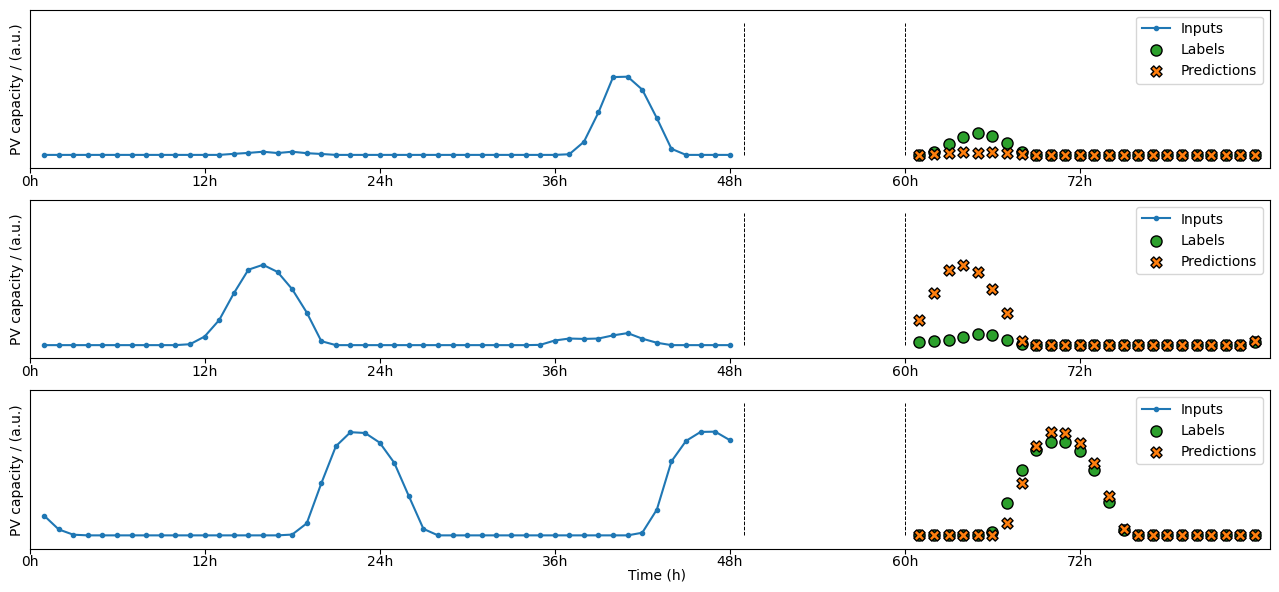

In [24]:
###### Input and labels #####################
##########################################
input_width = 48
label_width = 24
offset = 36

total_window_size = input_width + offset

input_slice = slice(0, input_width)
input_indices = np.arange(total_window_size)[input_slice]

label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
label_indices = np.arange(total_window_size)[labels_slice]

label_columns = ['electricity']
label_columns_indices = {name: i for i, name in enumerate(label_columns)}


#####  Sequences ###########
######################################
max_n = 3
seq_number = np.random.randint(0, 1000, max_n)

### Plot #######################
########################################
fig, axs = plt.subplots(nrows= max_n, ncols= 1, figsize=(16,7), sharex= True, sharey= True)

for n, ax in enumerate(axs):

    ax.plot(input_indices,X_test[seq_number[n],:,0], label='Inputs', marker='.')#, zorder=-10, c='b')
    ax.scatter(label_indices, y_test[seq_number[n],:,0], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    ax.scatter(label_indices, X_test[seq_number[n],12:-12,0], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

    ax.vlines(input_width, ymin=0, ymax=1, color='k', linewidth=0.7, linestyle='--')
    ax.vlines(label_start -1, ymin=0, ymax=1, color='k', linewidth=0.7, linestyle='--')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-1,84)

    # ax.set_axis_off()
    ax.set_yticks([])
    ax.set_ylabel('PV capacity / (a.u.)')

    x_labels = np.arange(total_window_size, step=12)
    ax.set_xticks([i - 1 for i in x_labels])
    ax.set_xticklabels([])

    for value in x_labels:
        ax.text(x= value-1, y=-0.2, s= f"{value}h", va='center', ha='center')

    ax.legend()

plt.text(x= 42, y=-0.3, s= f"Time (h)", va='center', ha='center')


# 2) PV models

## Model-1: RNN

The most simple model to be used is a simple RNN model. We simply start the Sequential architecture with an input Layer folllowed by a normalization layer, which will come in handy once we feed features from the weather forecast.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 48, 1)            3         
 ion)                                                            
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 24)                624       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
Total params: 1,227
Trainable params: 1,224
Non-trainable params: 3
_________________________________________________________________
None
✅ Results saved locally
✅ Model saved locally


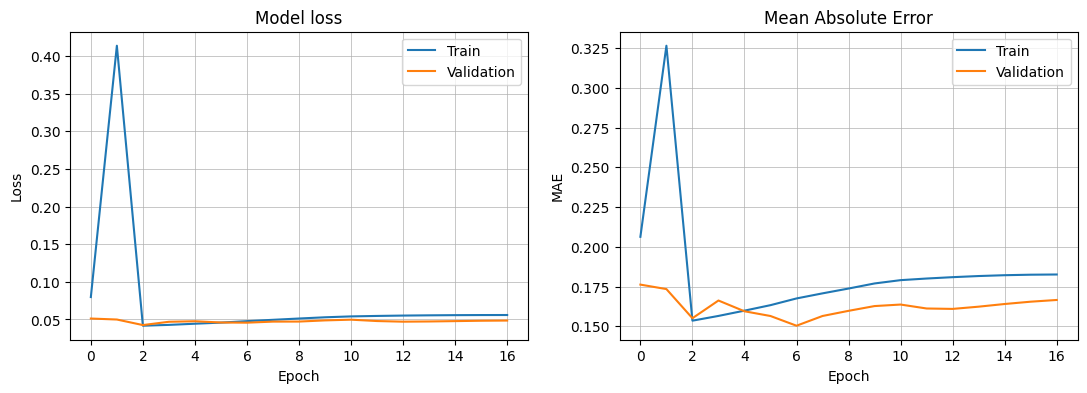


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...
✅ Model loaded from local disk
✅ Model evaluated, MAE: 0.15
✅ Results saved locally
✅ evaluate() done 



0.1528463214635849

In [35]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.SimpleRNN(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## Model-2: LSTM

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 48, 1)            3         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 24)                2496      
                                                                 
 dense_8 (Dense)             (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


2024-11-14 21:15:33.170744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:15:33.173534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:15:33.176229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-14 21:15:33.711318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:15:33.715055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:15:33.717486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


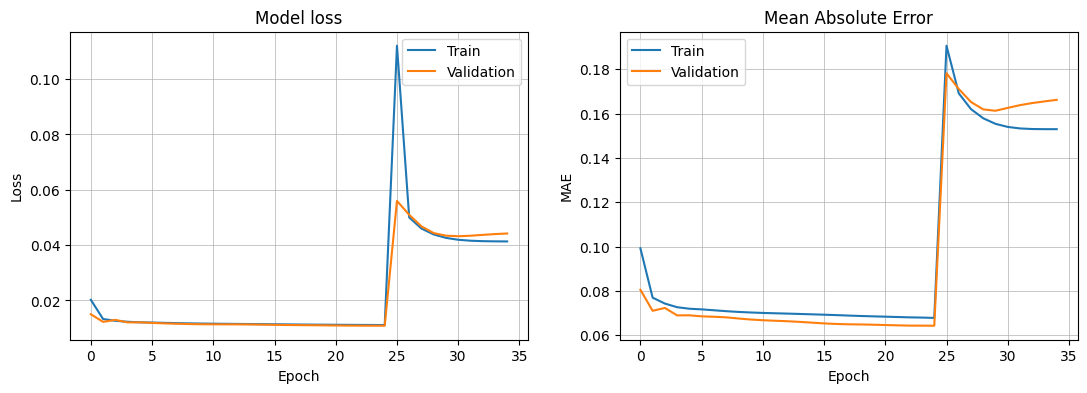


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 21:18:12.046669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:18:12.049577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:18:12.051526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 21:18:12.413857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:18:12.416764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:18:12.418620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



0.06394882500171661

In [ ]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## Model-3: GRU

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 48, 1)            3         
 tion)                                                           
                                                                 
 gru_1 (GRU)                 (None, 24)                1944      
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
Total params: 2,547
Trainable params: 2,544
Non-trainable params: 3
_________________________________________________________________


2024-11-14 21:26:59.111806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:26:59.114345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:26:59.116245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-14 21:26:59.610907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:26:59.614131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:26:59.616205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


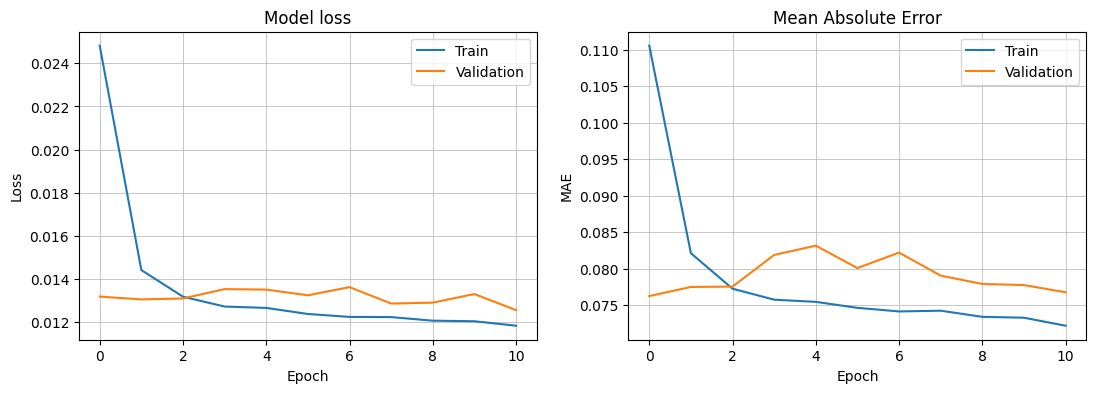


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 21:28:00.317754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:28:00.322137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:28:00.325364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 21:28:00.827350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:28:00.830671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:28:00.832676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.08
✅ Results saved locally
✅ evaluate() done 



0.07653853297233582

In [39]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-1
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.GRU(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## LSTM: learning rate 1e-2

Model: "sequential"


2024-11-15 23:13:02.678449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-15 23:13:02.684750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-15 23:13:02.691077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 1)            3         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________
None


2024-11-15 23:13:04.376133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-15 23:13:04.383674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-15 23:13:04.391088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


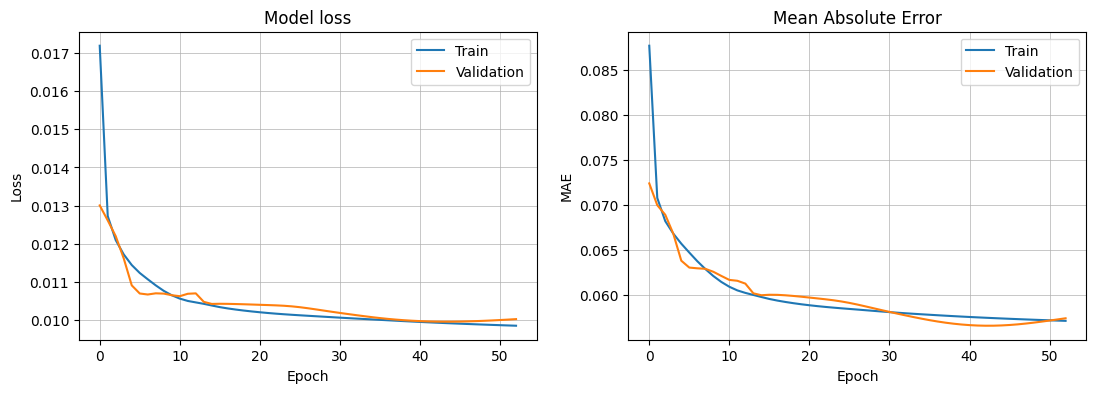


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-15 23:19:49.614874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-15 23:19:49.619432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-15 23:19:49.624994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-15 23:19:50.608103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-15 23:19:50.613515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-15 23:19:50.617008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



0.05636100098490715

In [31]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-2
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## LSTM: learning rate 1e-3

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliza  (None, 48, 1)            3         
 tion)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 24)                2496      
                                                                 
 dense_12 (Dense)            (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


2024-11-14 21:43:47.953969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:43:47.956948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:43:47.959795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-14 21:43:48.589715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:43:48.594178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:43:48.598666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


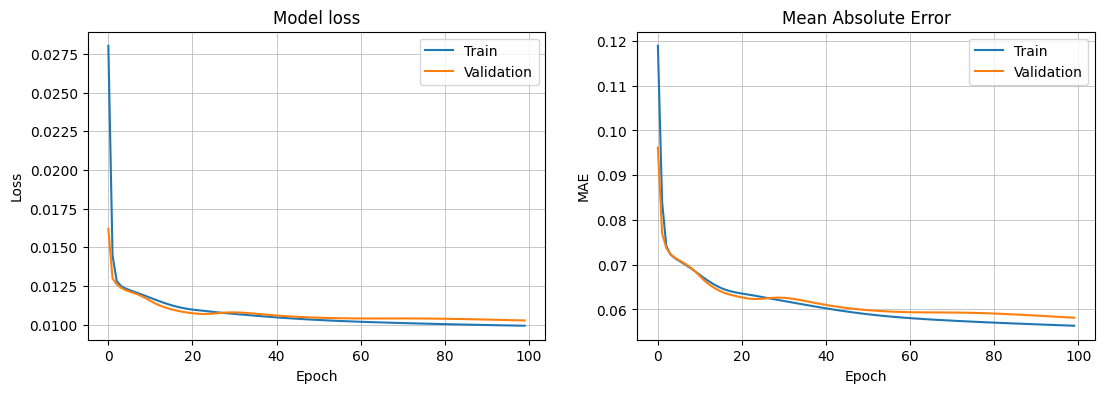


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 21:51:55.407468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:51:55.411175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:51:55.414055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 21:51:55.938746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:51:55.942143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:51:55.945490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



0.058936383575201035

In [41]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-3
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])


adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## LSTM: learning rate 1e-4

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 48, 1)            3         
 tion)                                                           
                                                                 
 lstm_4 (LSTM)               (None, 24)                2496      
                                                                 
 dense_13 (Dense)            (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


2024-11-14 21:51:56.878956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:51:56.881921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:51:56.883907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-14 21:51:57.336623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:51:57.340783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:51:57.343729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


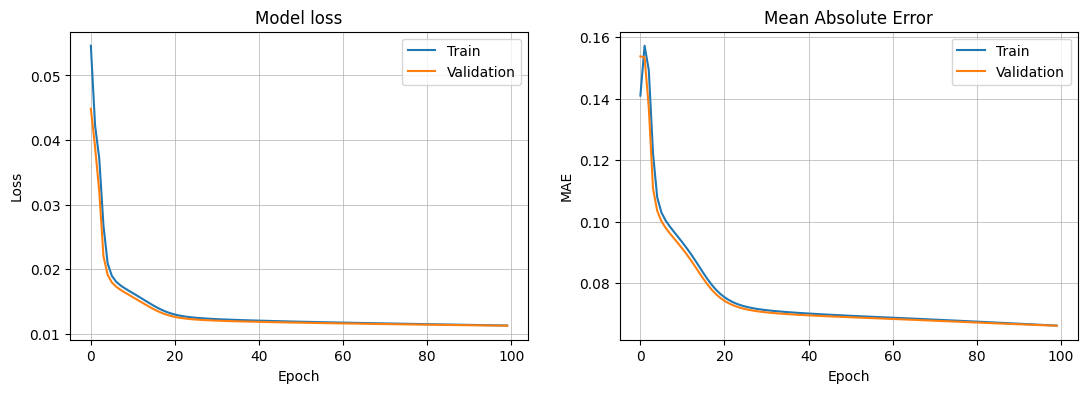


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 21:59:47.467436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:59:47.470250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:59:47.473154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 21:59:47.884991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 21:59:47.887576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 21:59:47.889476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.07
✅ Results saved locally
✅ evaluate() done 



0.06717415899038315

In [42]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-4
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()

## LSTM: learning rate 1e-3 - RMSprop Optimizer

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 48, 1)            3         
 tion)                                                           
                                                                 
 lstm_6 (LSTM)               (None, 24)                2496      
                                                                 
 dense_15 (Dense)            (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


2024-11-14 22:12:28.829308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 22:12:28.831777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 22:12:28.834330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None


2024-11-14 22:12:29.460701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 22:12:29.465043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 22:12:29.470091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Results saved locally
✅ Model saved locally


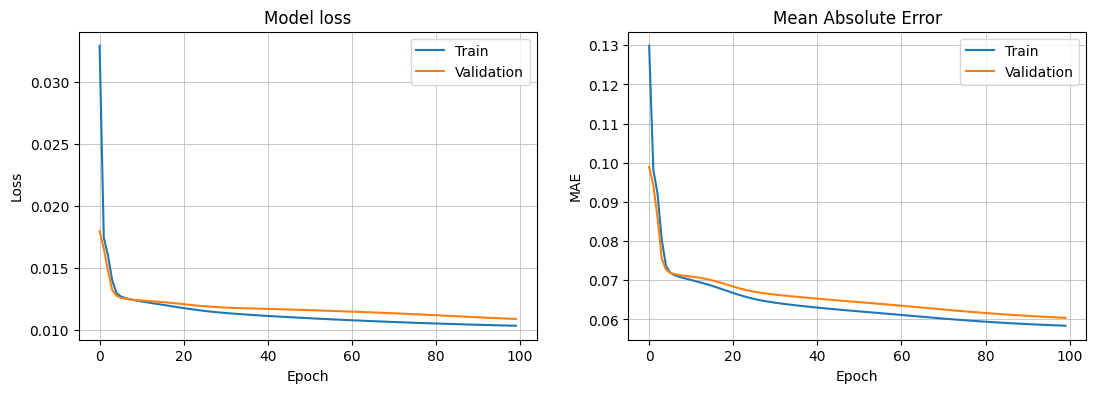


⭐️ Use case: evaluate

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from local registry...

Load latest model from disk...


2024-11-14 22:19:48.343295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 22:19:48.345698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 22:19:48.347634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk


2024-11-14 22:19:48.796012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-14 22:19:48.798985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-14 22:19:48.800850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model evaluated, MAE: 0.06
✅ Results saved locally
✅ evaluate() done 



0.060498420149087906

In [44]:
# 1 - RNN architecture
    # ======================

X_train, y_train = X, y
LEARNING_RATE = 1e-3
min_date_pv = '1980-01-01 00:00:00'
min_date_forecast = '2017-10-07 00:00:00'
max_date = '2019-12-31 23:00:00'

output_length = y_train.shape[1]

model = models.Sequential([
    ## 1.0 - Input Layer
    layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    ## 1.1 - Normalization Layer
    layers.Normalization(),
    ## 1.2 - Recurrent Layer
    layers.LSTM(units=24, activation='tanh', return_sequences = False),
    ## 1.3 - Predictive Dense Layers
    layers.Dense(output_length, activation='linear'),
    ])



adam = optimizers.Adam(learning_rate=LEARNING_RATE)
RMSprop = optimizers.RMSprop(learning_rate= LEARNING_RATE)
model.compile(loss='mse', optimizer=RMSprop, metrics=['mae'])

print(model.summary())

model, history = train_model(model, X, y)
val_mae = np.min(history.history['val_mae'])

params = dict(
    context="train",
    training_set_size=f'Training data from {min_date_pv} to {max_date}',
    row_count=len(X_train),
)

# Save results on the hard drive using power.ml_logic.registry
save_results(params=params, metrics=dict(mae=val_mae), history=history)

# Save model weight on the hard drive (and optionally on GCS too!)
save_model(model=model)
plot_loss_mae(history)
evaluate()